# The most advanced version so far to generated 3D curves. 

In [1]:
from matplotlib import pyplot as plt 
import numpy as np
import os
import math
import sys

from tifffile import imsave
import scipy.ndimage as ndimage
import scipy.signal as signal
%matplotlib inline
from skimage.draw import line_nd
from skimage.draw import line_aa
from skimage.draw import line
from skimage.draw import bezier_curve
from scipy.interpolate import CubicSpline
import random 
import elasticdeform
import os

In [12]:
def normalize(img_np, invert=False):
    img_min = np.min(img_np)
    img_max = np.max(img_np)

    new_min = 0
    new_max = 1
    img_normd = (img_np - img_min) * ((new_max - new_min) / (img_max - img_min)) + new_min

    if invert:
        img_normd = new_max - img_normd

    return img_normd

In [33]:
parent_dir = '/scratch/park/data/Banterle/4th/train'
if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

model = 'curved-haystack'
save_dir = os.path.join(parent_dir, 'simulation_data/', model)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [2]:
import numpy as np
from scipy.interpolate import make_interp_spline
import random

def rotate_around_center_of_mass_3d(x, y, z):
    """
    Rotates 3D points (x, y, z) around their center of mass by random angles.
    
    Parameters:
    x (np.ndarray): x-coordinates of the points.
    y (np.ndarray): y-coordinates of the points.
    z (np.ndarray): z-coordinates of the points.
    
    Returns:
    tuple: Rotated x, y, and z coordinates.
    """
    # Calculate the center of mass
    center_of_mass_x = x.mean()
    center_of_mass_y = y.mean()
    center_of_mass_z = z.mean()
    
    # Translate points so the center of mass is at the origin
    translated_x = x - center_of_mass_x
    translated_y = y - center_of_mass_y
    translated_z = z - center_of_mass_z
    
    # Generate random rotation angles between 0 and 2*pi for each axis
    angle_x = random.uniform(0, 2 * np.pi)
    angle_y = random.uniform(0, 2 * np.pi)
    angle_z = random.uniform(0, 2 * np.pi)
    
    # Create rotation matrices for each axis
    cos_x, sin_x = np.cos(angle_x), np.sin(angle_x)
    cos_y, sin_y = np.cos(angle_y), np.sin(angle_y)
    cos_z, sin_z = np.cos(angle_z), np.sin(angle_z)
    
    # Rotation matrix for X-axis
    rotation_matrix_x = np.array([
        [1, 0, 0],
        [0, cos_x, -sin_x],
        [0, sin_x, cos_x]
    ])
    
    # Rotation matrix for Y-axis
    rotation_matrix_y = np.array([
        [cos_y, 0, sin_y],
        [0, 1, 0],
        [-sin_y, 0, cos_y]
    ])
    
    # Rotation matrix for Z-axis
    rotation_matrix_z = np.array([
        [cos_z, -sin_z, 0],
        [sin_z, cos_z, 0],
        [0, 0, 1]
    ])
    
    # Combine the rotations into a single matrix
    rotation_matrix = rotation_matrix_z @ rotation_matrix_y @ rotation_matrix_x
    
    # Rotate the translated points using the combined rotation matrix
    rotated_points = np.dot(rotation_matrix, np.vstack((translated_x, translated_y, translated_z)))
    
    # Translate the points back to their original center of mass
    rotated_x = rotated_points[0, :] + center_of_mass_x
    rotated_y = rotated_points[1, :] + center_of_mass_y
    rotated_z = rotated_points[2, :] + center_of_mass_z
    
    return rotated_x, rotated_y, rotated_z

def get_3d_path_voxel_indices(num_paths=25, voxel_size=500):
    """
    Generates smooth random 3D paths with a random number of humps within a voxel space,
    rotates each path around its center of mass by random angles, and returns the voxel indices
    occupied by each path.
    
    Parameters:
    num_paths (int): Number of paths to generate.
    voxel_size (int): The size of the voxel space (width, height, and depth).
    
    Returns:
    list: A list of arrays, where each array contains the (x, y, z) voxel indices of a path.
    """
    paths_indices = []
    
    # Generate each path
    for _ in range(num_paths):
        # Randomly choose the number of humps (between 3 and 10 for better paths)
        num_humps = np.random.randint(3, 11)
        
        # Generate random x, y, and z-values and sort them for smooth curves
        t = np.sort(np.random.uniform(0, 1, num_humps * 2))
        x = np.random.uniform(0, voxel_size, num_humps * 2)
        y = np.random.uniform(0, voxel_size, num_humps * 2)
        z = np.random.uniform(0, voxel_size, num_humps * 2)
        
        # Create smooth paths using spline interpolation
        t_smooth = np.linspace(t.min(), t.max(), 10000)
        spline_x = make_interp_spline(t, x, k=3)
        spline_y = make_interp_spline(t, y, k=3)
        spline_z = make_interp_spline(t, z, k=3)
        x_smooth = spline_x(t_smooth)
        y_smooth = spline_y(t_smooth)
        z_smooth = spline_z(t_smooth)
        
        # Rotate the path around its center of mass
        rotated_x, rotated_y, rotated_z = rotate_around_center_of_mass_3d(x_smooth, y_smooth, z_smooth)
        
        # Discretize the coordinates into voxel indices and ensure they stay within the bounds
        voxel_x = np.clip(np.round(rotated_x).astype(int), 0, voxel_size - 1)
        voxel_y = np.clip(np.round(rotated_y).astype(int), 0, voxel_size - 1)
        voxel_z = np.clip(np.round(rotated_z).astype(int), 0, voxel_size - 1)
        
        # Combine x, y, and z into a single array of (x, y, z) voxel indices
        path_indices = np.vstack((voxel_x, voxel_y, voxel_z)).T
        
        # Remove duplicates to avoid redundant voxel positions
        # path_indices = np.unique(path_indices, axis=0)
        curve_form = []
        for pt_ind in range(len(path_indices)-1):
            x0, y0, z0 = path_indices[pt_ind,0], path_indices[pt_ind,1], path_indices[pt_ind,2]
            x1, y1, z1 = path_indices[pt_ind+1,0], path_indices[pt_ind+1,1], path_indices[pt_ind+1,2]
            line_x, line_y, line_z = line_nd([x0, y0, z0], [x1, y1, z1])
            line_points =  np.array([line_x, line_y, line_z]).transpose()
            # line_points = np.unique(line_points, axis=0)
            curve_form.append(line_points)
        continuous_curve = np.concatenate(curve_form, axis=0)
        # Append the voxel indices of this path to the list
        paths_indices.append(continuous_curve)
    
    return paths_indices


In [3]:
ROI_size = 400
# Example usage:
path_voxel_indices = get_3d_path_voxel_indices(num_paths=1000, voxel_size=ROI_size)

# Print the indices of the first path as an example
print("Voxel indices of the first path:")
print(path_voxel_indices[0])

Voxel indices of the first path:
[[399 399   0]
 [398 399   0]
 [397 399   0]
 ...
 [396 399   0]
 [397 399   0]
 [398 399   0]]


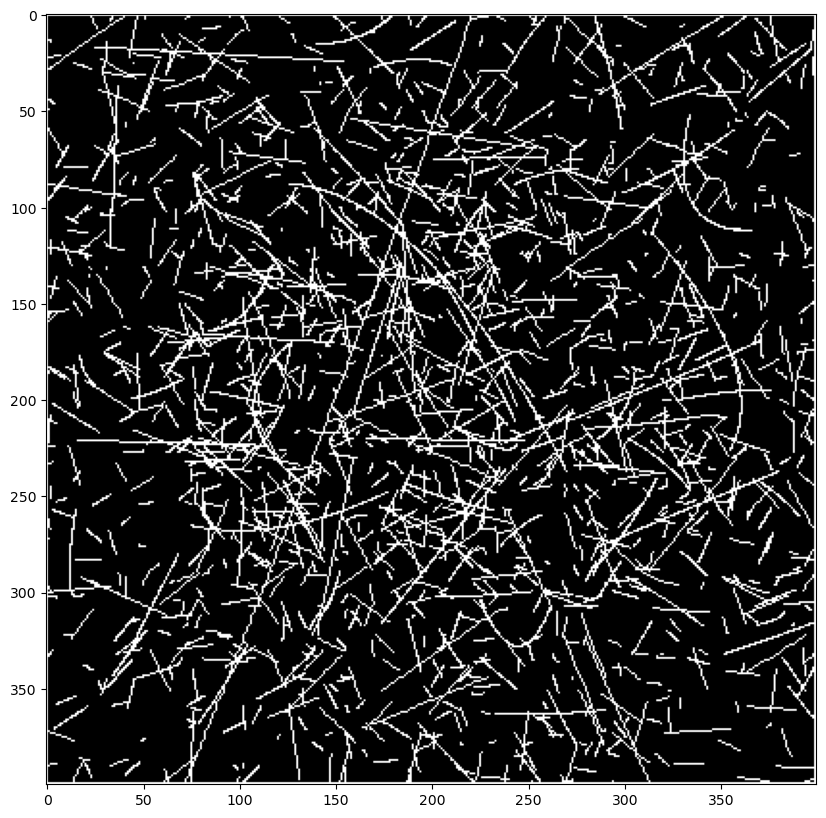

In [4]:
canvas_vol = np.zeros((ROI_size,ROI_size,ROI_size))
for path in path_voxel_indices:
    for pt in path:
        canvas_vol[pt[0], pt[1], pt[2]] = 100

canvas = np.amax(canvas_vol[25:35,:,:], axis=0)
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap = 'gray')

In [5]:
sigma_=0.7 #deformation parameter
points_= 25 #deformation parameter
canvas_vol = elasticdeform.deform_random_grid(canvas_vol, sigma=sigma_, points=points_)

In [6]:
canvas_vol = ndimage.uniform_filter(canvas_vol, size=3)

In [18]:
canvas_vol_blurred = signal.fftconvolve(canvas_vol, gau_filter, mode='same')

In [21]:
np.max(canvas_vol_blurred)

0.0

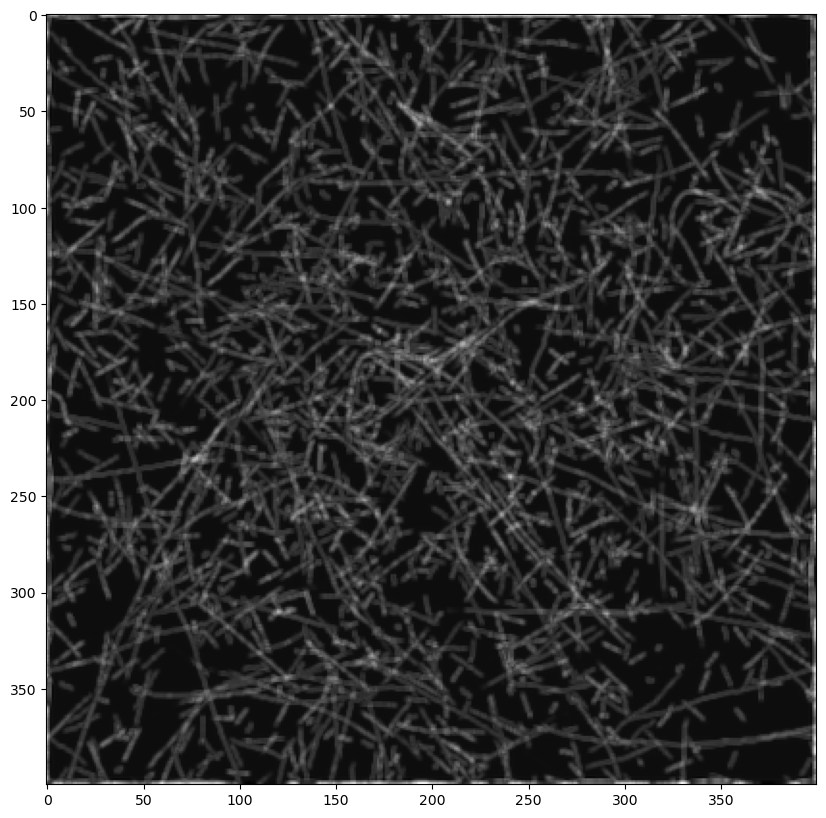

In [24]:
canvas = np.amax(canvas_vol[100:110,:,:], axis=0)
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap = 'gray')

In [25]:
canvas_vol_save = (canvas_vol-np.mean(canvas_vol))/np.std(canvas_vol)
canvas_vol_save = normalize(canvas_vol_save) * (2**16-1)
canvas_vol_save = canvas_vol_save.astype(np.uint16)

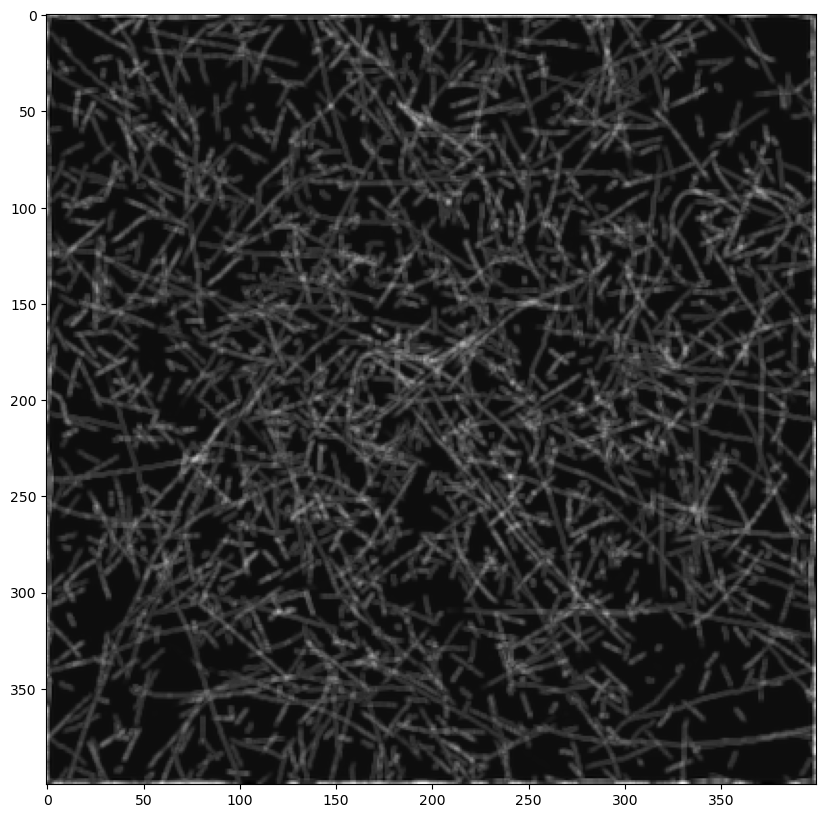

In [26]:
canvas = np.amax(canvas_vol_save[100:110,:,:], axis=0)
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap = 'gray')

In [29]:
from scipy.ndimage import zoom
canvas_vol_save = zoom(canvas_vol_save, (3,3,3))

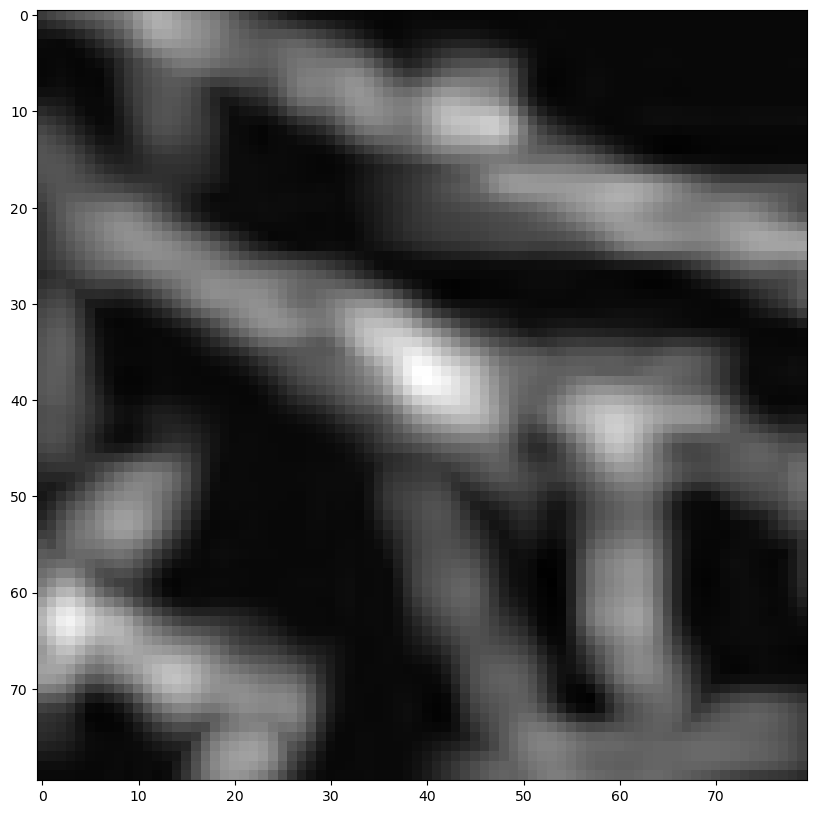

In [32]:
canvas = np.amax(canvas_vol_save[100:110,400:480,400:480], axis=0)
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap = 'gray')

In [34]:
imsave(save_dir + '/curved-haystack.tiff', canvas_vol_save)

# Note: don't forget to crop out the borders, the border artifacts from the clipping 